# jitcsim tutorial
### Explosive synchronization

Simulate explosive synchronization and hysteresis loop
in order parameter on a Frequency Gap-conditioned (FGC) network with Kuramoto model.

In [1]:
import sys
import numpy as np
import pylab as plt
from numpy import pi
import networkx as nx
from copy import copy
from time import time
from copy import deepcopy
from multiprocessing import Pool
from jitcsim.utility import flatten
from numpy.random import uniform, normal
from jitcsim.visualization import (plot_order,
                                   plot_degree_omega_distribution)
from jitcsim.models.kuramoto import Kuramoto_II
from jitcsim.utility import display_time
from jitcsim.networks import make_network

In [2]:
def simulateHalfLoop(direction):

    if direction == "backward":
        Couplings = copy(couplings[::-1])
    else:
        Couplings = copy(couplings)

    n = len(Couplings)
    orders = np.zeros(n)

    prev_phases = parameters['initial_state']

    for i in range(n):

        print("direction = {:10s}, coupling = {:10.6f}".format(
            direction, Couplings[i]))

        I = Kuramoto_II(parameters)
        I.set_initial_state(prev_phases)
        data = I.simulate([Couplings[i]])
        x = data['x']
        prev_phases = x[-1, :]
        orders[i] = np.mean(I.order_parameter(x))

    return orders

In [3]:
dt = 0.1
N = 50
t_initial = 0.0
t_final = 1500.0
t_transition = 400.0
noise_amplitude = 0.0
omega = uniform(low=0, high=1, size=N)
initial_state = uniform(-2*pi, 2*pi, N)
couplings = list(np.linspace(0.025, 0.040, 21))

ki = 20
gamma = 0.45
alpha = 0.0
num_processes = 2

net = make_network()
adj = net.fgc(N=N, k=ki, omega=omega, gamma=gamma)

parameters = {
    'N': N,
    'adj': adj,
    't_initial': 0.,
    "t_final": t_final,
    't_transition': t_transition,
    "interval": dt,                    # time interval for sampling

    "alpha": alpha,
    "omega": omega,
    'initial_state': initial_state,

    'integration_method': 'dopri5',
    'control': ['coupling'],
    "use_omp": False,
    "output": "data",
    "modulename": "km",
}

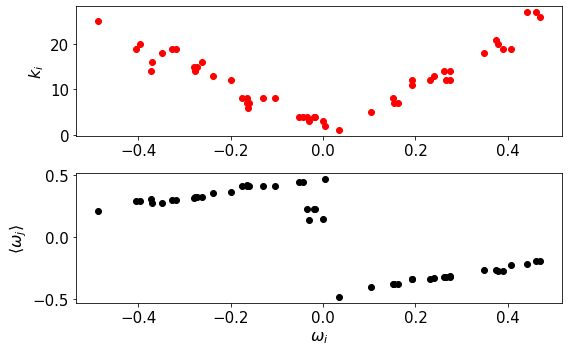

In [4]:
plot_degree_omega_distribution(adj, omega, close_fig=False)

In [5]:
I = Kuramoto_II(parameters)
I.compile()

start = time()
args = ["forward", "backward"]

with Pool(processes=num_processes) as pool:
    orders = (pool.map(simulateHalfLoop, args))

display_time(time()-start)

r_forward, r_backward = orders

saving file to data/km.so
direction = forward   , coupling =   0.025000direction = backward  , coupling =   0.040000

direction = backward  , coupling =   0.039250
direction = forward   , coupling =   0.025750
direction = backward  , coupling =   0.038500
direction = forward   , coupling =   0.026500
direction = backward  , coupling =   0.037750
direction = forward   , coupling =   0.027250
direction = backward  , coupling =   0.037000
direction = backward  , coupling =   0.036250
direction = forward   , coupling =   0.028000
direction = backward  , coupling =   0.035500
direction = forward   , coupling =   0.028750
direction = backward  , coupling =   0.034750
direction = forward   , coupling =   0.029500
direction = backward  , coupling =   0.034000
direction = forward   , coupling =   0.030250
direction = backward  , coupling =   0.033250
direction = forward   , coupling =   0.031000
direction = backward  , coupling =   0.032500
direction = backward  , coupling =   0.031750
directio

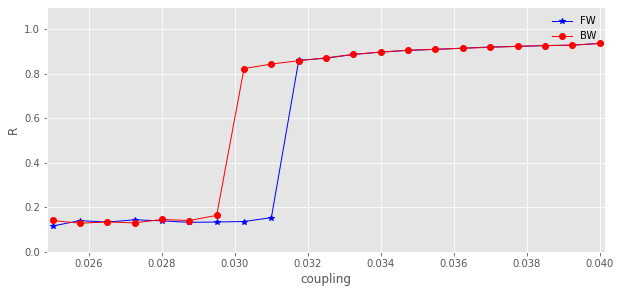

In [6]:
# save orders to npz file
np.savetxt("data/r.txt", np.column_stack((couplings,
                                          r_forward,
                                          r_backward)),
           fmt="%25.12f")

# plotting orders
plt.style.use('ggplot')
fig, ax = plt.subplots(1, figsize=(10, 4.5))
plot_order(couplings, r_forward,
           label="FW",
           close_fig=False,
           ax=ax,
           color="b",
           marker="*")
plot_order(couplings[::-1],
           r_backward,
           label="BW",
           ax=ax,
           color="r",
           marker="o",
           close_fig=False,
           xlabel="coupling",
           ylabel="R")
plt.savefig("data/expl.png", dpi=150)

